# Importações 

In [2]:
#pip install pandas matplotlib scikit-learn

In [1]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.stats import zscore
from collections import Counter
import numpy as np

In [65]:
file_path = r"C:\Users\Samsung\OneDrive\Área de Trabalho\pisi\TMDB_all_movies.csv"
df =  pd.read_csv(file_path)

# Filtros

## Filmes ja lançados (status = Released)
Filmes que ainda não foram lançados não possuem dados importantes para a análise

In [66]:
registros_antes = len(df)
df = df[df['status'] == 'Released']
registros_depois = len(df)
print(f"Registros perdidos com o filtro: {registros_antes - registros_depois}")

Registros perdidos com o filtro: 20606


## Registros duplicados
Não faz sentido ter o mesmo filme mais de uma vez

In [67]:
registros_antes = len(df)
df = df.drop_duplicates()
registros_depois = len(df)
print(f"Registros perdidos com o filtro: {registros_antes - registros_depois}")

Registros perdidos com o filtro: 0


### Duplicados por titulo e data de lançamento

In [68]:
duplicados = df[df.duplicated(subset=['title', 'release_date'], keep=False)]
exemplo = df[df['title'].isin(['The Eighth Clause', 'Battle: Freestyle'])].sort_values(by='title')
exemplo.head(10)

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,budget,imdb_id,...,spoken_languages,cast,director,director_of_photography,writers,producers,music_composer,imdb_rating,imdb_votes,poster_path
561073,785521,Battle: Freestyle,5.5,63.0,Released,2022-04-01,0.0,88.0,0.0,tt13350858,...,Norsk,"Morad Aziman, Bboy Junior, Bao Andre Nguyen, G...",Ingvild Søderlind,NaN,Martina Cecelia,"Christian Fredrik Martin, Marte Hansen, Synnøv...",NaN,4.7,682.0,/6D6QumiHEhnpZG12Ibjy2BxA6n4.jpg
603197,841524,The Eighth Clause,3.3,10.0,Released,2022-04-29,0.0,80.0,0.0,tt12969084,...,Español,"Paulina Dávila, Michel Duval, Christian Meier,...",Koko Stambuk,Eduardo Flores Torres,"Frank Ariza, Mario Tardón",NaN,NaN,4.4,418.0,/5CbVMeLvaGn87gx05waiIJ0JySr.jpg


In [69]:
registros_antes = len(df)
df = df.drop_duplicates(subset=['title', 'release_date'])
registros_depois = len(df)
print(f"Registros perdidos com o filtro: {registros_antes - registros_depois}")

Registros perdidos com o filtro: 8553


In [70]:
exemplo = df[df['title'].isin(['The Eighth Clause', 'Battle: Freestyle'])].sort_values(by='title')
exemplo.head()

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,budget,imdb_id,...,spoken_languages,cast,director,director_of_photography,writers,producers,music_composer,imdb_rating,imdb_votes,poster_path
561073,785521,Battle: Freestyle,5.5,63.0,Released,2022-04-01,0.0,88.0,0.0,tt13350858,...,Norsk,"Morad Aziman, Bboy Junior, Bao Andre Nguyen, G...",Ingvild Søderlind,NaN,Martina Cecelia,"Christian Fredrik Martin, Marte Hansen, Synnøv...",NaN,4.7,682.0,/6D6QumiHEhnpZG12Ibjy2BxA6n4.jpg
603197,841524,The Eighth Clause,3.3,10.0,Released,2022-04-29,0.0,80.0,0.0,tt12969084,...,Español,"Paulina Dávila, Michel Duval, Christian Meier,...",Koko Stambuk,Eduardo Flores Torres,"Frank Ariza, Mario Tardón",NaN,NaN,4.4,418.0,/5CbVMeLvaGn87gx05waiIJ0JySr.jpg


## Budget > 0
Filmes com budget igual a 0 ou negativo, representam inconssitência com as informações, trazendo erros para a analise

In [71]:
registros_antes = len(df)
df = df[df['budget'] > 0]
registros_depois = len(df)
print(f"Registros perdidos com o filtro: {registros_antes - registros_depois}")


Registros perdidos com o filtro: 1017275


## Runtime > 70
Filmes com runtime menores que 70 não são considerados longa-metragem, que é nosso foco

In [72]:
registros_antes = len(df)
df = df[df['runtime'] > 70]
registros_depois = len(df)
print(f"Registros perdidos com o filtro: {registros_antes - registros_depois}")

Registros perdidos com o filtro: 38312


## Vote_count > 30
Filmes com poucos votos, podem levantar erros estatisticos sobre a analise dos filmes, pois o target 'vote_average' poderá ficar enviesado

In [73]:
registros_antes = len(df)
df = df[df['vote_count'] > 30]
registros_depois = len(df)
print(f"Registros perdidos com o filtro: {registros_antes - registros_depois}")

Registros perdidos com o filtro: 15409


In [74]:
print(df.columns.tolist())

['id', 'title', 'vote_average', 'vote_count', 'status', 'release_date', 'revenue', 'runtime', 'budget', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'tagline', 'genres', 'production_companies', 'production_countries', 'spoken_languages', 'cast', 'director', 'director_of_photography', 'writers', 'producers', 'music_composer', 'imdb_rating', 'imdb_votes', 'poster_path']


In [75]:
# Verifica se a coluna 'director' existe
if 'music_composer' in df.columns:
    print("Quantidade de diretores de foto únicos:", df['music_composer'].nunique())
    print("Exemplo de filmes e seus diretores:")
    display(df[['title', 'music_composer']].head(10))
else:
    print("Coluna 'director' não encontrada no DataFrame.")

top_n = 30
top_directors = df['music_composer'].value_counts().nlargest(top_n).index.tolist()
print(f"Top {top_n} diretores mais frequentes: {top_directors}")

Quantidade de diretores de foto únicos: 3715
Exemplo de filmes e seus diretores:


,title,music_composer
2,Four Rooms,Combustible Edison
3,Judgment Night,Alan Silvestri
6,Star Wars,John Williams
7,Finding Nemo,Thomas Newman
8,Forrest Gump,Alan Silvestri
9,American Beauty,Thomas Newman
10,Citizen Kane,Bernard Herrmann
11,Dancer in the Dark,Björk
13,The Fifth Element,Éric Serra
14,Metropolis,"Otto Harzner, Gottfried Huppertz"


Top 30 diretores mais frequentes: ['James Newton Howard', 'Jerry Goldsmith', 'James Horner', 'John Debney', 'Mark Isham', 'Hans Zimmer', 'Danny Elfman', 'Alan Silvestri', 'John Williams', 'Christophe Beck', 'Alexandre Desplat', 'Carter Burwell', 'Marco Beltrami', 'Thomas Newman', 'David Newman', 'Howard Shore', 'Christopher Young', 'Graeme Revell', 'Brian Tyler', 'Elmer Bernstein', 'Theodore Shapiro', 'John Powell', 'Mark Mothersbaugh', 'Ennio Morricone', 'A.R. Rahman', 'Harry Gregson-Williams', 'Michael Giacchino', 'Rolfe Kent', 'Maurice Jarre', 'Randy Edelman']


## Removendo colunas que não serão utilizadas na análise
- Title -> não usaremos processamento textual
- Overview -> não usaremos processamento textual
- Production Companies -> Vale com o One Hot Encoding? 
- Revenue -> Vazamento de dados.
- Status -> registro unico agr, ent inutil
- Tagline -> não usaremos processamento textual e 85% dos registros são NaN
- vote_avarege -> TARGET 
- vote_count -> vazamento de dados.
- Credits -> Vale com o One Hot Encoding?
- Keywords -> não usaremos processamento textual e 71% dos registros são NaN
- Poster_path e Backdrop_path -> não faz sentido para a análise
- Recommendations -> não faz sentido para a análise, 95% dos valores são NaN, vazamento de dados

In [76]:
df = df.drop(columns=[
    'id','overview', 'revenue', 'status', 'tagline', 
    'poster_path', 'poster_path',
    "imdb_id" , "director_of_photography" , 'music_composer' , "overview" , "original_title",
])
df.drop(columns=['writers', 'production_countries' ,'producers'], inplace=True)
df.drop(columns=['director' ,'cast'], inplace=True)
df.drop(columns=['spoken_languages'], inplace=True)

# Colunas que serão utilizadas na análise
print("Colunas que serão utilizadas na análise:")
print(df.columns)

Colunas que serão utilizadas na análise:
Index(['title', 'vote_average', 'vote_count', 'release_date', 'runtime',
       'budget', 'original_language', 'popularity', 'genres',
       'production_companies', 'imdb_rating', 'imdb_votes'],
      dtype='object')


## Limpando todos os valores nulos

In [77]:
registros_antes = len(df)
df = df.dropna()
registros_depois = len(df)
print(f"Registros perdidos com o filtro: {registros_antes - registros_depois}")

Registros perdidos com o filtro: 147


# Ajustando colunas 

In [78]:
def multi_hot_top_n(df, col, top_n=19):
    # Flatten todas as listas para contar os mais frequentes
    all_values = [item for sublist in df[col] for item in sublist]
    top = pd.Series(all_values).value_counts().nlargest(top_n).index.tolist()

    # Substitui os que não estão no top por 'Outros'
    def filter_top(vals):
        return [v.strip() if v.strip() in top else 'Outros' for v in vals]

    filtered = df[col].apply(filter_top)

    mlb = MultiLabelBinarizer()
    result = pd.DataFrame(mlb.fit_transform(filtered), columns=mlb.classes_, index=df.index)

    return result

## Data de lançamento
- Transformando em duas colunas, uma responsável pelo ano de lançamento e outra pelo mês de lançamento

In [79]:
# Tratando a data
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_year'] = df['release_date'].dt.year
df['release_month'] = df['release_date'].dt.month
df.drop(columns=['release_date'], inplace=True)

## Generos cinematográficos 

In [18]:
##*
#import re

#def padronizar_generos(genero):
    #if isinstance(genero, list):
        # Junta todos os gêneros da lista com hífen
     #   return '-'.join([g.strip() for g in genero if g.strip()])
    #if isinstance(genero, str):
        # Remove colchetes, aspas, etc
      #  genero = genero.strip("[]'\" ")
     #   # Separa por vírgula, pipe ou hífen e junta com hífen
    #    partes = re.split(r'[,|/-]', genero)
   #     partes = [p.strip() for p in partes if p.strip()]
  #      return '-'.join(partes)
 #   return 'Outros'

#df['genres'] = df['genres'].apply(padronizar_generos)

# Agora cada filme terá gêneros compostos no formato "Ação-Drama-Comédia" etc.
##print(df['genres'].value_counts().head(10))


In [80]:
generos_unicos = df['genres'].unique()
print("Gêneros únicos encontrados:")
for genero in generos_unicos:
    print(genero)

Gêneros únicos encontrados:
Comedy
Action, Crime, Thriller
Adventure, Action, Science Fiction
Animation, Family
Comedy, Drama, Romance
Drama
Mystery, Drama
Drama, Crime
Science Fiction, Action, Adventure
Drama, Science Fiction
Drama, Romance
Documentary
Adventure, Fantasy, Action
Action, Crime
Drama, War
Western
Animation, Comedy, Family
Science Fiction, Drama, Romance
Drama, Thriller
Drama, Thriller, Crime
Science Fiction, Mystery, Adventure
Science Fiction, Thriller, Mystery
Drama, Music
Crime, Drama, Action
Crime, Thriller, Drama, War
Comedy, Science Fiction
Drama, Music, Romance
Drama, Comedy, Music
Adventure, Thriller, Science Fiction
Comedy, Fantasy, Science Fiction
Mystery, Thriller
Science Fiction, Drama, Thriller
Drama, Adventure, Action, History
Adventure, Animation, Fantasy
Drama, Thriller, Horror
Adventure, Action
Comedy, Crime, Action
Crime, Drama, Mystery
Action, Thriller, Science Fiction, Adventure
Action, Comedy, Crime
Action, Drama, Adventure
Comedy, Drama
Comedy, Crim

Melhorando a tabela de generos , usar o codigo abaixo 

In [81]:
import re

def extrair_todos_generos(genero):
    if isinstance(genero, list):
        return [str(g).strip() for g in genero if str(g).strip()]
    if isinstance(genero, str):
        genero = genero.strip("[]'\" ")
        # Separa por hífen, vírgula ou pipe
        partes = re.split(r'[-,|]', genero)
        return [p.strip() for p in partes if p.strip()]
    return ['Outros']

# Aplica para obter todos os gêneros
df['genres'] = df['genres'].apply(extrair_todos_generos)

# Conta todos os gêneros (flatten)
from collections import Counter
all_genres = [g for sublist in df['genres'] for g in sublist]
contagem = Counter(all_genres)

# Define como raro os que aparecem menos de 100 vezes
generos_raros = [g for g, count in contagem.items() if count < 100]

def substituir_raros_lista(generos):
    return [g if g not in generos_raros else 'Outros' for g in generos]

df['genres'] = df['genres'].apply(substituir_raros_lista)

# Multi-hot encoding dos gêneros mais comuns (exemplo: top 19)
from sklearn.preprocessing import MultiLabelBinarizer
top_n = 19
top_generos = pd.Series([g for sublist in df['genres'] for g in sublist]).value_counts().nlargest(top_n).index.tolist()

def filtrar_top_generos(generos):
    return [g if g in top_generos else 'Outros' for g in generos]

df['genres'] = df['genres'].apply(filtrar_top_generos)

mlb = MultiLabelBinarizer()
genres_encoded = pd.DataFrame(mlb.fit_transform(df['genres']), columns=mlb.classes_, index=df.index)

df = pd.concat([df.drop(['genres'], axis=1), genres_encoded], axis=1)

In [ ]:
"""

import re

def extrair_genero_principal(genero):
    # Se for lista, pega o primeiro elemento (já string)
    if isinstance(genero, list):
        if len(genero) > 0:
            return str(genero[0]).strip()
        else:
            return 'Outros'
    # Se for string, remove colchetes e aspas e pega o primeiro gênero
    if isinstance(genero, str):
        genero = genero.strip("[]'\" ")
        # Separa por hífen, vírgula ou pipe
        partes = re.split(r'[-,|]', genero)
        return partes[0].strip()
    return 'Outros'

# Extrai o gênero principal
df['genres'] = df['genres'].apply(extrair_genero_principal)

# Conta os gêneros principais
contagem = Counter(df['genres'])

# Define como raro os que aparecem menos de 100 vezes
generos_raros = [g for g, count in contagem.items() if count < 100]

def substituir_raros(genero):
    return genero if genero not in generos_raros else 'Outros'

df['genres'] = df['genres'].apply(substituir_raros)

# Reconta os gêneros agora que os raros foram substituídos por "Outros"
contagem_atualizada = Counter(df['genres'])

# Converte para Series para ordenar e visualizar melhor
genero_series = pd.Series(contagem_atualizada).sort_values(ascending=False)

# Exibe o resultado
print(genero_series)
print(f"\nTotal de gêneros únicos: {len(genero_series)}")

"""

Drama              2948
Comedy             2596
Action             1881
Horror             1250
Adventure           683
Crime               627
Thriller            603
Science Fiction     389
Animation           362
Romance             315
Family              275
Fantasy             264
Mystery             150
Documentary         146
War                 141
Music               126
Western             114
History             113
Outros               21
dtype: int64

Total de gêneros únicos: 19


In [82]:
# Mostra as colunas de gênero
genero_cols = [col for col in df.columns if col in ['Action', 'Adventure', 'Comedy', 'Drama', 'Horror', 'Romance', 'Thriller', 'Outros']]  # ajuste conforme seus gêneros

# Exibe as primeiras linhas com as colunas de gênero
print(df[genero_cols + ['title']].head(10))

# Verifica se algum filme tem mais de um gênero marcado
df['num_generos'] = df[genero_cols].sum(axis=1)
print(df[['title', 'num_generos']].head(10))
print("Filmes com mais de um gênero:", (df['num_generos'] > 1).sum())


    Action  Adventure  Comedy  Drama  Horror  Romance  Thriller  \
2        0          0       1      0       0        0         0   
3        1          0       0      0       0        0         1   
6        1          1       0      0       0        0         0   
7        0          0       0      0       0        0         0   
8        0          0       1      1       0        1         0   
9        0          0       0      1       0        0         0   
10       0          0       0      1       0        0         0   
11       0          0       0      1       0        0         0   
13       1          1       0      0       0        0         0   
14       0          0       0      1       0        0         0   

                 title  
2           Four Rooms  
3       Judgment Night  
6            Star Wars  
7         Finding Nemo  
8         Forrest Gump  
9      American Beauty  
10        Citizen Kane  
11  Dancer in the Dark  
13   The Fifth Element  
14          

In [85]:
df.drop(columns=['num_generos'], inplace=True)
df.head(10)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13004 entries, 2 to 979294
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   title                 13004 non-null  object 
 1   vote_average          13004 non-null  float64
 2   vote_count            13004 non-null  float64
 3   runtime               13004 non-null  float64
 4   budget                13004 non-null  float64
 5   original_language     13004 non-null  object 
 6   popularity            13004 non-null  float64
 7   production_companies  13004 non-null  object 
 8   imdb_rating           13004 non-null  float64
 9   imdb_votes            13004 non-null  float64
 10  release_year          13004 non-null  int32  
 11  release_month         13004 non-null  int32  
 12  Action                13004 non-null  int64  
 13  Adventure             13004 non-null  int64  
 14  Animation             13004 non-null  int64  
 15  Comedy                1

In [22]:
#df_copy = df.copy()

#df_copy['genres'] = df_copy['genres'].apply(lambda x: [x] if isinstance(x, str) else x)

#genres_encoded = multi_hot_top_n(df_copy, 'genres', top_n=19)

#df_copy= pd.concat([df_copy.drop(['genres'], axis=1),
#               genres_encoded], axis=1)
#df_copy.head(10)

#df_copy.info()


## Ajustando coluna da production_companies

In [86]:
teste = df['production_companies'].apply(lambda x: x.split('-')).copy()
teste = teste.explode().reset_index(drop=True)
production_companies_counts = teste.value_counts() # Apply value_counts directly to the Series
print(production_companies_counts.head(20))
print(len(production_companies_counts))

production_companies
Goldwyn                    443
Mayer                      298
Metro                      194
Paramount Pictures         111
20th Century Fox            98
Warner Bros. Pictures       79
Universal Pictures          70
Columbia Pictures           53
Walt Disney Productions     36
RKO Radio Pictures          36
The Asylum                  32
New Line Cinema             27
Orion Pictures              25
Rhône                       22
Globus Productions          22
DreamWorks Animation        22
TriStar Pictures            21
Marvel Studios              20
The Cannon Group, Golan     18
Yash Raj Films              17
Name: count, dtype: int64
11851


In [87]:

def garantir_lista_empresas(x):
    if isinstance(x, list):
        if all(isinstance(i, str) for i in x):
            return x
        else:
            return [''.join(x)]
    elif isinstance(x, str):
        # Supondo que as empresas estejam separadas por hífen
        return [i.strip() for i in x.split('-') if i.strip()]
    else:
        return ['Outros']

df['production_companies'] = df['production_companies'].apply(garantir_lista_empresas)
companies_encoded = multi_hot_top_n(df, 'production_companies', top_n=19)

df = pd.concat([df.drop(['production_companies'], axis=1),
                companies_encoded], axis=1)


In [90]:

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13004 entries, 2 to 979294
Data columns (total 50 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   title                    13004 non-null  object 
 1   vote_average             13004 non-null  float64
 2   vote_count               13004 non-null  float64
 3   runtime                  13004 non-null  float64
 4   budget                   13004 non-null  float64
 5   original_language        13004 non-null  object 
 6   popularity               13004 non-null  float64
 7   imdb_rating              13004 non-null  float64
 8   imdb_votes               13004 non-null  float64
 9   release_year             13004 non-null  int32  
 10  release_month            13004 non-null  int32  
 11  Action                   13004 non-null  int64  
 12  Adventure                13004 non-null  int64  
 13  Animation                13004 non-null  int64  
 14  Comedy                   1

In [91]:
df = df.copy()

df['popularity_per_budget'] = df['popularity'] / (df['budget'] + 1)
df['vote_weighted'] = df['vote_average'] * df['vote_count']
df['runtime_per_budget'] = df['runtime'] / (df['budget'] + 1)
df['vote_popularity_weighted'] = df['vote_average'] * df['popularity']
import numpy as np
df['budget_log'] = np.log1p(df['budget'])
df['vote_count_log'] = np.log1p(df['vote_count'])

df.head(10)

,title,vote_average,vote_count,runtime,budget,original_language,popularity,imdb_rating,imdb_votes,release_year,...,TriStar Pictures,Universal Pictures,Walt Disney Productions,Warner Bros. Pictures,popularity_per_budget,vote_weighted,runtime_per_budget,vote_popularity_weighted,budget_log,vote_count_log
2,Four Rooms,5.900,2698.0,98.0,4000000.0,en,2.7943,6.7,114450.0,1995,...,0,0,0,0,6.985748e-07,15918.200,0.000024,16.486370,15.201805,7.900637
3,Judgment Night,6.500,351.0,109.0,21000000.0,en,1.8302,6.6,20057.0,1993,...,0,0,0,0,8.715238e-08,2281.500,0.000005,11.896300,16.860033,5.863631
6,Star Wars,8.200,21225.0,121.0,11000000.0,en,48.6637,8.6,1516686.0,1977,...,0,0,0,0,4.423972e-06,174045.000,0.000011,399.042340,16.213406,9.962982
7,Finding Nemo,7.800,19711.0,100.0,94000000.0,en,16.3107,8.2,1164187.0,2003,...,0,0,0,0,1.735181e-07,153745.800,0.000001,127.223460,18.358805,9.888983
8,Forrest Gump,8.468,28297.0,142.0,55000000.0,en,16.8306,8.8,2389590.0,1994,...,0,0,0,0,3.060109e-07,239618.996,0.000003,142.521521,17.822844,10.250546
9,American Beauty,8.006,12395.0,122.0,15000000.0,en,7.6210,8.3,1252051.0,1999,...,0,0,0,0,5.080666e-07,99234.370,0.000008,61.013726,16.523561,9.425129
10,Citizen Kane,8.000,5692.0,119.0,839727.0,en,5.0732,8.3,483151.0,1941,...,0,0,0,0,6.041480e-06,45536.000,0.000142,40.585600,13.640833,8.646993
11,Dancer in the Dark,7.900,1868.0,140.0,12500000.0,en,3.2226,7.9,121043.0,2000,...,0,0,0,0,2.578080e-07,14757.200,0.000011,25.458540,16.341239,7.533159
13,The Fifth Element,7.555,11057.0,126.0,90000000.0,fr,12.6709,7.6,528737.0,1997,...,0,0,0,0,1.407878e-07,83535.635,0.000001,95.728649,18.315320,9.310909
14,Metropolis,8.106,2875.0,153.0,5300000.0,de,4.3733,8.3,195225.0,1927,...,0,0,0,0,8.251508e-07,23304.750,0.000029,35.449970,15.483218,7.964156


## Transformando  em variáveis numéricas e adicionando zscore 

In [92]:
# 1. Remover colunas indesejadas
colunas_ruins = ['-', 'a', 'e', 'i', 'n', 'o', 'r', 's', 't']
df = df.drop(columns=colunas_ruins, errors='ignore')

# 2. Remover colunas duplicadas (ex: duas "Outros")
df = df.loc[:, ~df.columns.duplicated()]

# 3. Definir colunas numéricas (incluindo gêneros one-hot)
features_numericas = [
    'popularity',
    'budget',
    'runtime',
    'vote_average',
    'vote_count',
    'popularity_per_budget',
    'vote_weighted',
    'runtime_per_budget',
    'vote_popularity_weighted'
]

df['budget'] = df['budget'].apply(lambda x: np.log1p(x))
df['vote_count'] = np.log1p(df['vote_count'])
display(df.columns)

# 4. Aplicar z-score e filtrar outliers
df_z = df[features_numericas].apply(zscore)
df = df[(df_z.abs() < 3).all(axis=1)]


Index(['title', 'vote_average', 'vote_count', 'runtime', 'budget',
       'original_language', 'popularity', 'imdb_rating', 'imdb_votes',
       'release_year', 'release_month', 'Action', 'Adventure', 'Animation',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
       'TV Movie', 'Thriller', 'War', 'Western', '20th Century Fox',
       'Columbia Pictures', 'DreamWorks Animation', 'Globus Productions',
       'Goldwyn', 'Marvel Studios', 'Mayer', 'Metro', 'New Line Cinema',
       'Orion Pictures', 'Outros', 'Paramount Pictures', 'RKO Radio Pictures',
       'Rhône', 'The Asylum', 'The Cannon Group, Golan', 'TriStar Pictures',
       'Universal Pictures', 'Walt Disney Productions',
       'Warner Bros. Pictures', 'popularity_per_budget', 'vote_weighted',
       'runtime_per_budget', 'vote_popularity_weighted', 'budget_log',
       'vote_count_log'],
      dtype='object')

In [93]:
idioma_para_continente = {
    # América do Norte
    'en': 'America_do_Norte',

    # Ásia
    'ko': 'Asia',
    'cn': 'Asia', # Chinês (Simplificado/Mandarin)
    'hi': 'Asia', # Hindi
    'ja': 'Asia', # Japonês
    'zh': 'Asia', # Chinês (Genérico/Variedades)
    'te': 'Asia', # Telugu
    'ar': 'Asia', # Árabe (Também África)
    'ml': 'Asia', # Malayalam
    'kn': 'Asia', # Kannada
    'ta': 'Asia', # Tamil
    'km': 'Asia', # Khmer
    'he': 'Asia', # Hebraico
    'bn': 'Asia', # Bengali
    'ms': 'Asia', # Malaio
    'bo': 'Asia', # Tibetano
    'kk': 'Asia', # Cazaque (Também Europa)
    'ka': 'Asia', # Georgiano (Também Europa)
    'ku': 'Asia', # Curdo (Também Europa)
    'ur': 'Asia', # Urdu
    'ps': 'Asia', # Pashto
    'mr': 'Asia', # Marathi
    'lo': 'Asia', # Laosiano
    'ne': 'Asia', # Nepalês


    # Europa
    'es': 'Europa', # Espanhol (Também Américas)
    'no': 'Europa', # Norueguês
    'fi': 'Europa', # Finlandês
    'ru': 'Europa', # Russo (Também Ásia)
    'uk': 'Europa', # Ucraniano
    'nl': 'Europa', # Holandês
    'it': 'Europa', # Italiano
    'fr': 'Europa', # Francês (Também Américas, África)
    'pl': 'Europa', # Polonês
    'pt': 'Europa', # Português (Também Américas, África)
    'de': 'Europa', # Alemão
    'ro': 'Europa', # Romeno
    'sr': 'Europa', # Sérvio
    'sv': 'Europa', # Sueco
    'gl': 'Europa', # Galego
    'tr': 'Europa', # Turco (Também Ásia)
    'cs': 'Europa', # Tcheco
    'el': 'Europa', # Grego
    'ga': 'Europa', # Irlandês
    'mk': 'Europa', # Macedônio
    'sh': 'Europa', # Sérvio-Croata
    'hu': 'Europa', # Húngaro
    'eu': 'Europa', # Basco
    'lv': 'Europa', # Letão
    'sk': 'Europa', # Eslovaco
    'et': 'Europa', # Estoniano
    'hy': 'Europa', # Armênio (Também Ásia)
    'sq': 'Europa', # Albanês
    'se': 'Europa', # Sami Setentrional
    'sl': 'Europa', # Esloveno
    'cy': 'Europa', # Galês
    'lt': 'Europa', # Lituano
    'hr': 'Europa', # Croata
    'bg': 'Europa', # Búlgaro
    'yi': 'Europa', # Iídiche
    'eo': 'Europa', # Esperanto
    'nb': 'Europa', # Bokmål Norueguês


    # África
    'sw': 'Africa', # Suaíli
    'af': 'Africa', # Africâner
    'am': 'Africa', # Amárico
    'zu': 'Africa', # Zulu
    'xh': 'Africa', # Xhosa
    'wo': 'Africa', # Uolofe
    'bm': 'Africa', # Bambara


    # América do Sul
    'qu': 'America_do_Sul', # Quechua
    'ay': 'America_do_Sul', # Aimará


    # Oceania
    'mi': 'Oceania', # Maori


    # Outros / Desconhecido / Códigos Especiais
    'id': 'Asia',   # Indonésio (Geralmente Ásia, mas para simplificar, pode agrupar)
    'is': 'Europa',   # Islandês (Europa, mas pode ser um grupo separado se for muito raro)
    'tl': 'Asia',   # Tagalo (Filipino) (Ásia, mas pode agrupar)
    'dz': 'Asia',   # Dzongkha (Ásia, Butão)
    'xx': 'Outros',   # Sem linguagem / Linguagem desconhecida (Código especial)
    'la': 'Outros',   # Latim (Histórico)
    'vi': 'Asia',   # Vietnamita (Ásia, mas pode agrupar)
    'bs': 'Europa',   # Bósnio (Europa, mas pode agrupar)
    'iu': 'America_do_Norte',   # Inuktitut (América do Norte, Ártico)
    'pa': 'Asia',   # Punjabi (Ásia, mas pode agrupar)
    'th': 'Asia', # Tailandês (Ásia, mas para manter consistência com Ásia acima)

    # Adicionar os idiomas restantes que não foram listados explicitamente acima
    # ...
}

df['continent'] = df['original_language'].map(idioma_para_continente)
df['continent'] = df['continent'].fillna('Outros')
continent_encoded = pd.get_dummies(df['continent'], prefix='continent')

df = pd.concat([df.drop(columns=['continent', 'original_language'], errors='ignore'), continent_encoded], axis=1)

# Adicione ao features_numericas:
features_numericas += [col for col in continent_encoded.columns if col not in features_numericas]
print(df.columns)

Index(['title', 'vote_average', 'vote_count', 'runtime', 'budget',
       'popularity', 'imdb_rating', 'imdb_votes', 'release_year',
       'release_month', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie',
       'Thriller', 'War', 'Western', '20th Century Fox', 'Columbia Pictures',
       'DreamWorks Animation', 'Globus Productions', 'Goldwyn',
       'Marvel Studios', 'Mayer', 'Metro', 'New Line Cinema', 'Orion Pictures',
       'Outros', 'Paramount Pictures', 'RKO Radio Pictures', 'Rhône',
       'The Asylum', 'The Cannon Group, Golan', 'TriStar Pictures',
       'Universal Pictures', 'Walt Disney Productions',
       'Warner Bros. Pictures', 'popularity_per_budget', 'vote_weighted',
       'runtime_per_budget', 'vote_popularity_weighted', 'budget_log',
       'vote_count_log', 'continent_Africa', 'continent_America_do_Norte',
       'co

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12244 entries, 2 to 979294
Data columns (total 60 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   title                       12244 non-null  object 
 1   vote_average                12244 non-null  float64
 2   vote_count                  12244 non-null  float64
 3   runtime                     12244 non-null  float64
 4   budget                      12244 non-null  float64
 5   popularity                  12244 non-null  float64
 6   imdb_rating                 12244 non-null  float64
 7   imdb_votes                  12244 non-null  float64
 8   release_year                12244 non-null  int32  
 9   release_month               12244 non-null  int32  
 10  Action                      12244 non-null  int64  
 11  Adventure                   12244 non-null  int64  
 12  Animation                   12244 non-null  int64  
 13  Comedy                      12244 n

## Escala Logaritmica no budget

In [95]:
def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

cont_cols = ['popularity', 'budget', 'runtime', 'vote_count']

df = remove_outliers_iqr(df, cont_cols)
print(f"Amostras antes: {len(df)} - Amostras depois: {len(df)}")

Amostras antes: 10766 - Amostras depois: 10766


In [96]:
df['popularity_per_budget'] = df['popularity'] / (df['budget'] + 1)
df['vote_weighted'] = df['vote_average'] * df['vote_count']
df['runtime_per_budget'] = df['runtime'] / (df['budget'] + 1)
df['vote_popularity_weighted'] = df['vote_average'] * df['popularity']
import numpy as np
df['budget_log'] = np.log1p(df['budget'])
df['vote_count_log'] = np.log1p(df['vote_count'])

In [97]:
print(df.columns)

Index(['title', 'vote_average', 'vote_count', 'runtime', 'budget',
       'popularity', 'imdb_rating', 'imdb_votes', 'release_year',
       'release_month', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie',
       'Thriller', 'War', 'Western', '20th Century Fox', 'Columbia Pictures',
       'DreamWorks Animation', 'Globus Productions', 'Goldwyn',
       'Marvel Studios', 'Mayer', 'Metro', 'New Line Cinema', 'Orion Pictures',
       'Outros', 'Paramount Pictures', 'RKO Radio Pictures', 'Rhône',
       'The Asylum', 'The Cannon Group, Golan', 'TriStar Pictures',
       'Universal Pictures', 'Walt Disney Productions',
       'Warner Bros. Pictures', 'popularity_per_budget', 'vote_weighted',
       'runtime_per_budget', 'vote_popularity_weighted', 'budget_log',
       'vote_count_log', 'continent_Africa', 'continent_America_do_Norte',
       'co

In [98]:

features = [
    # Variáveis numéricas principais
    'vote_average', 'vote_count', 'runtime', 'budget', 
    'popularity', 'imdb_rating', 'imdb_votes',
    'release_year', 'release_month',

    # Gêneros (one-hot)
    'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 
    'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 
    'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 
    'TV Movie', 'Thriller', 'War', 'Western',

    # Produtoras (one-hot)
    '20th Century Fox', 'Columbia Pictures', 'DreamWorks Animation',
    'Globus Productions', 'Goldwyn', 'Marvel Studios', 'Mayer', 
    'Metro', 'New Line Cinema', 'Orion Pictures', 'Outros',
    'Paramount Pictures', 'RKO Radio Pictures', 'Rhône',
    'The Asylum', 'The Cannon Group, Golan', 'TriStar Pictures',
    'Universal Pictures', 'Walt Disney Productions',
    'Warner Bros. Pictures',

    # Variáveis derivadas
    'popularity_per_budget', 'vote_weighted', 'runtime_per_budget',
    'vote_popularity_weighted', 'budget_log', 'vote_count_log',

    # Continentes (one-hot)
    'continent_Africa', 'continent_America_do_Norte', 
    'continent_Asia', 'continent_Europa', 'continent_Outros'
]

vote_average                  0
vote_count                    0
runtime                       0
budget                        0
popularity                    0
imdb_rating                   0
imdb_votes                    0
release_year                  0
release_month                 0
Action                        0
Adventure                     0
Animation                     0
Comedy                        0
Crime                         0
Documentary                   0
Drama                         0
Family                        0
Fantasy                       0
History                       0
Horror                        0
Music                         0
Mystery                       0
Romance                       0
Science Fiction               0
TV Movie                      0
Thriller                      0
War                           0
Western                       0
20th Century Fox              0
Columbia Pictures             0
DreamWorks Animation          0
Globus P

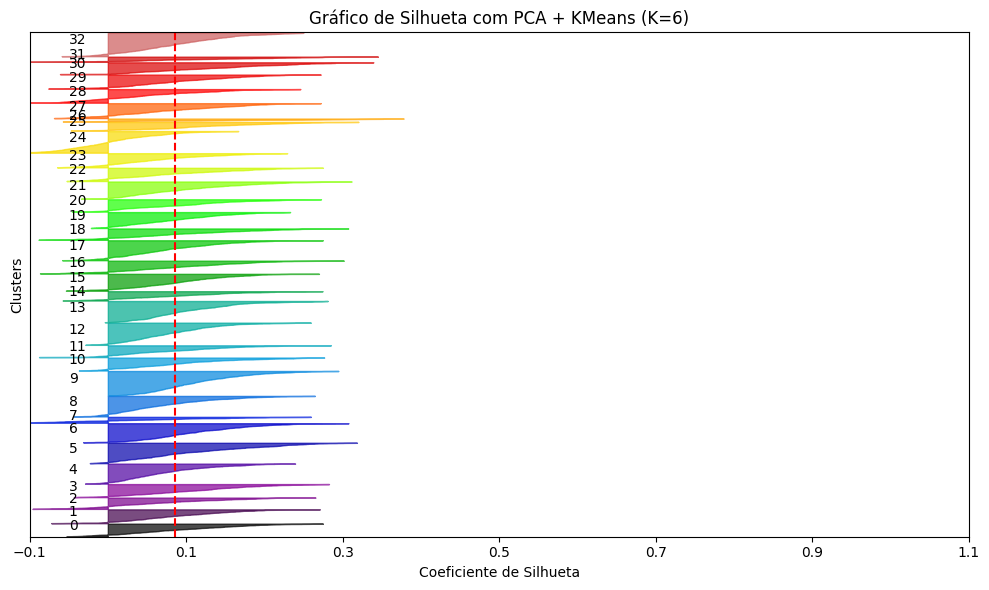

Média das variáveis por cluster:


,vote_average,vote_count,runtime,budget,popularity,imdb_rating,imdb_votes,release_year,release_month,Action,...,vote_weighted,runtime_per_budget,vote_popularity_weighted,budget_log,vote_count_log,continent_Africa,continent_America_do_Norte,continent_Asia,continent_Europa,continent_Outros
cluster,,,,,,,,,,,,,,,,,,,,,
0,5.74,4.95,90.84,13.20,1.48,5.70,9752.29,1980.10,6.67,0.23,...,28.62,6.41,8.53,2.65,1.77,0.0,0.88,0.04,0.08,0.00
1,5.71,5.27,94.93,16.16,7.73,5.37,12271.58,2007.52,6.71,0.23,...,30.12,5.54,43.98,2.84,1.82,0.0,0.82,0.01,0.17,0.00
2,6.88,6.99,114.69,16.54,7.30,6.66,61166.02,2012.85,6.98,0.24,...,48.12,6.54,50.10,2.86,2.07,0.0,0.83,0.08,0.08,0.00
3,6.63,8.37,110.92,17.63,4.83,6.73,246988.60,2007.34,7.04,0.42,...,55.41,5.96,31.84,2.92,2.24,0.0,0.99,0.01,0.00,0.00
4,5.87,5.35,101.68,16.29,1.65,5.89,14025.46,1998.29,6.07,0.48,...,31.49,5.89,9.72,2.85,1.84,0.0,0.95,0.03,0.01,0.00
5,4.99,4.47,91.94,14.70,1.36,4.47,4465.97,2008.04,6.67,0.34,...,22.32,5.87,6.75,2.75,1.69,0.0,0.95,0.02,0.03,0.00
6,6.79,5.04,108.09,15.21,1.32,6.79,7088.42,2014.13,6.87,0.08,...,34.30,6.68,9.01,2.78,1.79,0.0,0.03,0.09,0.86,0.02
7,7.53,8.02,103.61,14.54,5.39,7.67,194126.02,1978.59,7.28,0.16,...,60.36,6.68,40.44,2.74,2.20,0.0,0.83,0.07,0.10,0.00
8,5.15,5.47,92.98,16.73,1.71,4.70,15273.13,2002.23,6.30,0.38,...,28.16,5.25,8.79,2.87,1.86,0.0,0.97,0.01,0.02,0.00


In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from IPython.display import display

# 1. Seleção das colunas (numéricas + derivadas)
# Usa a lista 'features' já definida no notebook
print(df[features].isnull().sum())

# 2. Escalonamento com RobustScaler
X = df[features].copy()
X.to_csv(r'C:\Users\Samsung\OneDrive\Área de Trabalho\X.csv', index=False)  
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# 3. PCA mantendo 95% da variância
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print(f"Número de componentes PCA escolhidos: {X_pca.shape[1]}")

# 4. KMeans com 6 clusters
n_clusters = 33
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=100)
cluster_labels = kmeans.fit_predict(X_pca)

# 5. Silhouette Score
silhouette_avg = silhouette_score(X_pca, cluster_labels)
print(f"Silhouette Score médio com PCA: {silhouette_avg:.3f}")

# 6. Distribuição de amostras por cluster
unique, counts = np.unique(cluster_labels, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f'Cluster {cluster}: {count} amostras ({count / len(cluster_labels):.2%} do total)')

# 7. Gráfico de silhueta
sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(X_pca) + (n_clusters + 1) * 10])

y_lower = 10
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7
    )

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax1.set_title("Gráfico de Silhueta com PCA + KMeans (K=6)")
ax1.set_xlabel("Coeficiente de Silhueta")
ax1.set_ylabel("Clusters")
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_yticks([])
ax1.set_xticks(np.arange(-0.1, 1.1, 0.2))

plt.tight_layout()
plt.show()

# Adiciona os rótulos dos clusters ao DataFrame original
df_analisado = df.copy()
df_analisado['cluster'] = cluster_labels  # cluster_labels deve vir do seu KMeans

for i in range(min(3, X_pca.shape[1])):
    df_analisado[f'pca_{i}'] = X_pca[:, i]

# Calcula a média de cada feature por cluster
resumo_por_cluster = df_analisado.groupby('cluster')[features].mean().round(2)

# Exibe o resumo
print("Média das variáveis por cluster:")
display(resumo_por_cluster)


In [100]:
print(df_analisado.columns)
print(df_analisado[['title']].head())

Index(['title', 'vote_average', 'vote_count', 'runtime', 'budget',
       'popularity', 'imdb_rating', 'imdb_votes', 'release_year',
       'release_month', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie',
       'Thriller', 'War', 'Western', '20th Century Fox', 'Columbia Pictures',
       'DreamWorks Animation', 'Globus Productions', 'Goldwyn',
       'Marvel Studios', 'Mayer', 'Metro', 'New Line Cinema', 'Orion Pictures',
       'Outros', 'Paramount Pictures', 'RKO Radio Pictures', 'Rhône',
       'The Asylum', 'The Cannon Group, Golan', 'TriStar Pictures',
       'Universal Pictures', 'Walt Disney Productions',
       'Warner Bros. Pictures', 'popularity_per_budget', 'vote_weighted',
       'runtime_per_budget', 'vote_popularity_weighted', 'budget_log',
       'vote_count_log', 'continent_Africa', 'continent_America_do_Norte',
       'co

K=2: Silhouette = 0.261
K=3: Silhouette = 0.138
K=4: Silhouette = 0.130
K=5: Silhouette = 0.138
K=6: Silhouette = 0.138
K=7: Silhouette = 0.122
K=8: Silhouette = 0.109
K=9: Silhouette = 0.104
K=10: Silhouette = 0.100
K=11: Silhouette = 0.099
K=12: Silhouette = 0.093
K=13: Silhouette = 0.093
K=14: Silhouette = 0.092
K=15: Silhouette = 0.091
K=16: Silhouette = 0.091
K=17: Silhouette = 0.090
K=18: Silhouette = 0.088
K=19: Silhouette = 0.088
K=20: Silhouette = 0.087
K=21: Silhouette = 0.085
K=22: Silhouette = 0.084
K=23: Silhouette = 0.079
K=24: Silhouette = 0.079
K=25: Silhouette = 0.080
K=26: Silhouette = 0.080
K=27: Silhouette = 0.079
K=28: Silhouette = 0.081
K=29: Silhouette = 0.080
K=30: Silhouette = 0.081
K=31: Silhouette = 0.079
K=32: Silhouette = 0.079
K=33: Silhouette = 0.080
K=34: Silhouette = 0.077
K=35: Silhouette = 0.078
K=36: Silhouette = 0.077
K=37: Silhouette = 0.077


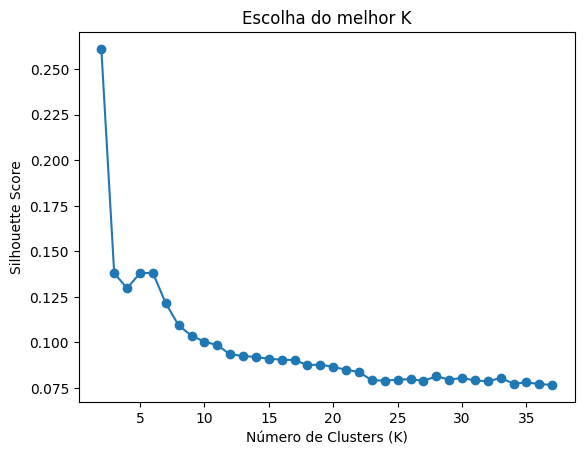

In [64]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sil_scores = []
K_range = range(2, 38) 

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=100)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)
    print(f"K={k}: Silhouette = {score:.3f}")

plt.plot(K_range, sil_scores, marker='o')
plt.xlabel("Número de Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Escolha do melhor K")
plt.show()


In [101]:
df.head(10)

,title,vote_average,vote_count,runtime,budget,popularity,imdb_rating,imdb_votes,release_year,release_month,...,vote_weighted,runtime_per_budget,vote_popularity_weighted,budget_log,vote_count_log,continent_Africa,continent_America_do_Norte,continent_Asia,continent_Europa,continent_Outros
2,Four Rooms,5.900,7.900637,98.0,15.201805,2.7943,6.7,114450.0,1995,12,...,46.613756,6.048709,16.486370,2.785123,2.186123,False,True,False,False,False
3,Judgment Night,6.500,5.863631,109.0,16.860033,1.8302,6.6,20057.0,1993,10,...,38.113603,6.103012,11.896300,2.882565,1.926237,False,True,False,False,False
10,Citizen Kane,8.000,8.646993,119.0,13.640833,5.0732,8.3,483151.0,1941,4,...,69.175941,8.127953,40.585600,2.683814,2.266646,False,True,False,False,False
11,Dancer in the Dark,7.900,7.533159,140.0,16.341239,3.2226,7.9,121043.0,2000,9,...,59.511955,8.073241,25.458540,2.853087,2.143960,False,True,False,False,False
15,My Life Without Me,6.000,6.159095,106.0,14.731802,1.4310,7.4,26278.0,2003,3,...,36.954572,6.737944,8.586000,2.755684,1.968384,False,True,False,False,False
19,Jarhead,6.700,7.998335,123.0,18.092177,4.2637,7.0,216482.0,2005,11,...,53.588847,6.442429,28.566790,2.949279,2.197040,False,True,False,False,False
20,Walk on Water,6.900,4.465908,103.0,14.151984,0.7255,7.3,7150.0,2004,2,...,30.814766,6.797790,5.005950,2.718131,1.698530,False,False,True,False,False
22,Apocalypse Now,8.272,9.051110,147.0,17.265498,8.1883,8.4,744959.0,1979,5,...,74.870783,8.047960,67.733618,2.905014,2.307683,False,True,False,False,False
23,Unforgiven,7.900,8.432942,130.0,16.482739,6.2133,8.2,456038.0,1992,8,...,66.620239,7.435906,49.085070,2.861214,2.244208,False,True,False,False,False
24,The Simpsons Movie,7.000,9.007734,87.0,18.132999,9.3590,7.3,358017.0,2007,7,...,63.054141,4.547118,65.513000,2.951415,2.303358,False,True,False,False,False


In [112]:
from sklearn.metrics import pairwise_distances

def recomendar_filmes(nome_filme, df, n_recomendacoes=5):
    # Verifica se o filme existe no DataFrame
    if nome_filme not in df['title'].values:
        print("Filme não encontrado.")
        return []

    # Obtém os dados do filme
    filme_row = df[df['title'] == nome_filme].iloc[0]

    # Mostra o cluster do filme base
    cluster = filme_row['cluster']
    print(f"'{nome_filme}' pertence ao cluster {cluster}")

    # Obtém o vetor PCA do filme
    filme_pca = filme_row[['pca_0', 'pca_1', 'pca_2']].values.reshape(1, -1)

    # Filtra os filmes do mesmo cluster
    cluster_filmes = df[df['cluster'] == cluster]

    # Calcula as distâncias
    from sklearn.metrics import pairwise_distances
    distancias = pairwise_distances(cluster_filmes[['pca_0', 'pca_1', 'pca_2']], filme_pca).reshape(-1)

    # Associa distâncias e ordena
    cluster_filmes = cluster_filmes.copy()
    cluster_filmes['distancia'] = distancias

    # Exclui o próprio filme e seleciona os mais próximos
    recomendados = cluster_filmes[cluster_filmes['title'] != nome_filme].sort_values('distancia').head(n_recomendacoes)

    return recomendados['title'].tolist()


recs = recomendar_filmes("The Simpsons Movie", df_analisado)
print("Recomendações:", recs)

'The Simpsons Movie' pertence ao cluster 25
Recomendações: ['The Expendables', 'Click', 'The Dictator', 'TRON: Legacy', 'Night at the Museum']


In [109]:
df_analisado.head(20)


,title,vote_average,vote_count,runtime,budget,popularity,imdb_rating,imdb_votes,release_year,release_month,...,vote_count_log,continent_Africa,continent_America_do_Norte,continent_Asia,continent_Europa,continent_Outros,cluster,pca_0,pca_1,pca_2
2,Four Rooms,5.900,7.900637,98.0,15.201805,2.7943,6.7,114450.0,1995,12,...,2.186123,False,True,False,False,False,15,0.954117,0.094698,-0.512269
3,Judgment Night,6.500,5.863631,109.0,16.860033,1.8302,6.6,20057.0,1993,10,...,1.926237,False,True,False,False,False,4,-0.435555,-0.055212,-0.859687
10,Citizen Kane,8.000,8.646993,119.0,13.640833,5.0732,8.3,483151.0,1941,4,...,2.266646,False,True,False,False,False,26,6.549281,4.205787,-0.360861
11,Dancer in the Dark,7.900,7.533159,140.0,16.341239,3.2226,7.9,121043.0,2000,9,...,2.143960,False,True,False,False,False,10,2.132478,2.372201,-0.799328
15,My Life Without Me,6.000,6.159095,106.0,14.731802,1.4310,7.4,26278.0,2003,3,...,1.968384,False,True,False,False,False,13,-0.883805,0.920170,-0.505349
19,Jarhead,6.700,7.998335,123.0,18.092177,4.2637,7.0,216482.0,2005,11,...,2.197040,False,True,False,False,False,3,3.454081,0.297795,-1.178333
20,Walk on Water,6.900,4.465908,103.0,14.151984,0.7255,7.3,7150.0,2004,2,...,1.698530,False,False,True,False,False,23,-1.799720,1.466038,-0.317360
22,Apocalypse Now,8.272,9.051110,147.0,17.265498,8.1883,8.4,744959.0,1979,5,...,2.307683,False,True,False,False,False,26,11.544021,3.242831,-1.154861
23,Unforgiven,7.900,8.432942,130.0,16.482739,6.2133,8.2,456038.0,1992,8,...,2.244208,False,True,False,False,False,25,7.135023,2.211686,-0.658178
24,The Simpsons Movie,7.000,9.007734,87.0,18.132999,9.3590,7.3,358017.0,2007,7,...,2.303358,False,True,False,False,False,25,6.715528,-1.273985,0.735315
